In [59]:
import pandas as pd
import geopandas
import seaborn as sns
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt

The FSA map is from Canada Post - it's a set of geometry polygons for each Forward Sortation Area in the country.

In [60]:
FSA_map = geopandas.read_file('FSA_Shapefile')

In [61]:
#Filter down the FSA to only Ontario
FSA_map = FSA_map[FSA_map['PRUID'] == "35"]

In [62]:
FSA_map

,CFSAUID,DGUID,PRUID,PRNAME,LANDAREA,geometry
643,K0A,2021A0011K0A,35,Ontario,3072.8212,"MULTIPOLYGON (((7409003.466 1184446.8, 7409023..."
644,K0B,2021A0011K0B,35,Ontario,1223.8974,"POLYGON ((7547053.517 1235912.877, 7546990.603..."
645,K0C,2021A0011K0C,35,Ontario,2470.9420,"MULTIPOLYGON (((7526037.231 1142505.114, 75260..."
646,K0E,2021A0011K0E,35,Ontario,1979.2436,"MULTIPOLYGON (((7467094.206 1056970.191, 74670..."
647,K0G,2021A0011K0G,35,Ontario,2675.2361,"MULTIPOLYGON (((7486734.166 1157795.989, 74867..."
...,...,...,...,...,...,...
1158,P7L,2021A0011P7L,35,Ontario,873.7825,"MULTIPOLYGON (((6371302.877 1320255.226, 63712..."
1159,P8N,2021A0011P8N,35,Ontario,563.9007,"MULTIPOLYGON (((6153386.603 1498864.751, 61533..."
1160,P8T,2021A0011P8T,35,Ontario,207.6624,"POLYGON ((6202287.383 1555004.729, 6203163.126..."
1161,P9A,2021A0011P9A,35,Ontario,378.0704,"MULTIPOLYGON (((6077019.174 1378743.449, 60770..."


Now we get census data at the FSA level - this is a monster file that contains data for every single FSA in the country, so we're going to need to get it down to a manageable size pretty quickly.

In [63]:
Census_data = pd.read_csv('98-401-X2021013_English_CSV_data.csv', encoding='latin-1')

In [64]:
SW_ON_Census_Data = Census_data.loc[Census_data['GEO_NAME'].str.match(r'[MN]\d\w', na=False)]

In [65]:
SW_ON_Census_Data = SW_ON_Census_Data[SW_ON_Census_Data['CHARACTERISTIC_ID'] == 1]

In [66]:
Filtered_SW_ON_Census_Data = SW_ON_Census_Data[['GEO_NAME', 'C1_COUNT_TOTAL']]

In [67]:
Filtered_SW_ON_Census_Data = Filtered_SW_ON_Census_Data.rename(columns={
    'GEO_NAME': 'FSA',
    'C1_COUNT_TOTAL': '2021 Population'
})

In [68]:
Filtered_SW_ON_Census_Data.set_index('FSA')

,2021 Population
FSA,
M1B,65555.0
M1C,35642.0
M1E,48033.0
M1G,30894.0
M1H,23964.0
...,...
N9H,13173.0
N9J,20089.0
N9K,2757.0


Lets look at the distribution a little bit

<Axes: >

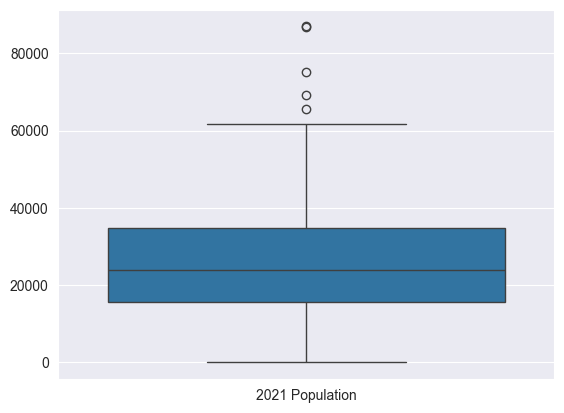

In [69]:
sns.boxplot(Filtered_SW_ON_Census_Data)

<Axes: ylabel='Count'>

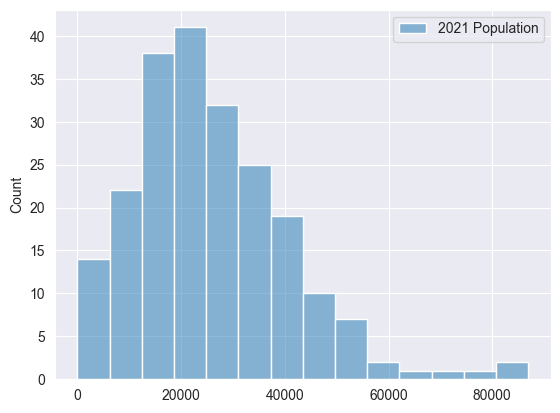

In [70]:
sns.histplot(Filtered_SW_ON_Census_Data, kde=False)

Now we can make a multiplier per 1000 population to start normalizing everything else to.

In [71]:
Filtered_SW_ON_Census_Data['Per 1000 Multiplier'] = 1000 / Filtered_SW_ON_Census_Data['2021 Population']

Great - now let's pull in the COVID case data. This comes from the City of Toronto, and has a row for each case that includes the FSA (see a pattern yet?), the date of the case, as well as a few flags for signs of a more serious case such as intubation and hospital or ICU admission.

In [72]:
covid_cases = pd.read_csv('COVID19 cases.csv')

In [73]:
# Do a bit of data wrangling - get the date column to be a date, and turn yes/no columns into 1/0 columns for later.

covid_cases['Episode Date'] = pd.to_datetime(covid_cases['Episode Date'])
cols_to_convert = ['Ever Hospitalized', 'Ever in ICU', 'Ever Intubated']
for col in cols_to_convert:
    covid_cases[col] = covid_cases[col].map({'Yes': 1, 'No': 0})

Lets take a look at how the data is distributed and see if there's anything fun to see.

In [74]:
FSA_Cases = covid_cases['FSA'].value_counts().to_frame()

<Axes: ylabel='Count'>

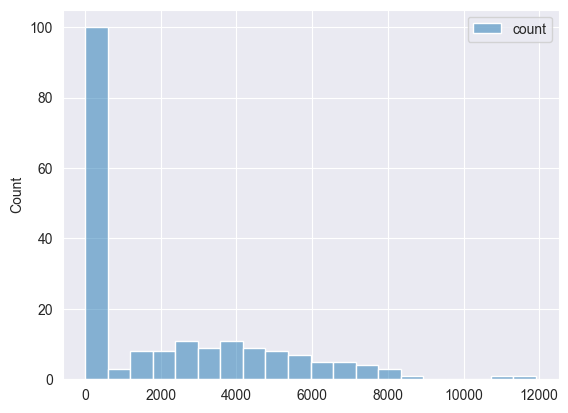

In [75]:
sns.histplot(FSA_Cases, bins=20)

Well that's...interesting - going in and looking at the data itself, there's a whole bunch of FSA with only a single case, and some hand checking reveals that they aren't real FSA's!

Lets see what FSA's in there don't appear in the official list

In [76]:
funky_FSA_codes = FSA_Cases[~FSA_Cases.index.isin(FSA_map['CFSAUID'])]

In [77]:
funky_FSA_codes['count'].sum()

np.int64(448)

Given that these funky (erroneous) FSA's are such a small group out of the whole number of cases, I'm just going to get rid of them.

In [78]:
Real_FSA_Cases = FSA_Cases[FSA_Cases.index.isin(FSA_map['CFSAUID'])]

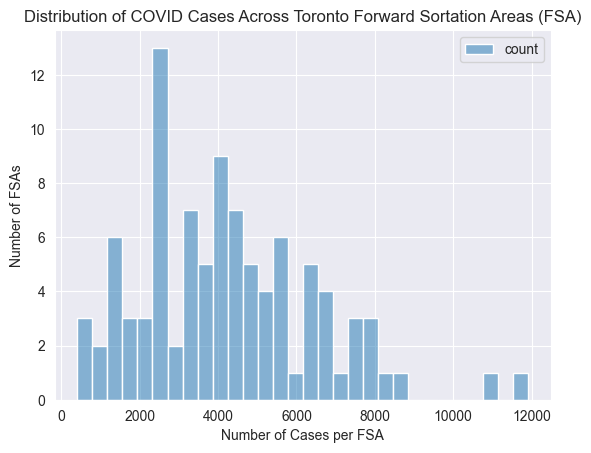

In [79]:
sns.histplot(Real_FSA_Cases, bins=30)
plt.xlabel('Number of Cases per FSA')
plt.ylabel('Number of FSAs')
plt.title('Distribution of COVID Cases Across Toronto Forward Sortation Areas (FSA)')
plt.show()

Aaah, that's better already. Dare I say it's getting closer to normal? - now let's adjust per 1000 and see what that gets us.

In [80]:
multiplier = Filtered_SW_ON_Census_Data.set_index('FSA')['Per 1000 Multiplier']

In [81]:
Real_FSA_Cases = Real_FSA_Cases.merge(
    multiplier,
    left_index=True,           # Use FSA index from Real_FSA_Cases
    right_on='FSA',           # Match with FSA column in multiplier
    how='left'                # Keep all rows from Real_FSA_Cases
)

In [82]:
Real_FSA_Cases['Covid Cases per 1000'] = Real_FSA_Cases['count'] * Real_FSA_Cases['Per 1000 Multiplier']


<Axes: xlabel='Covid Cases per 1000', ylabel='Count'>

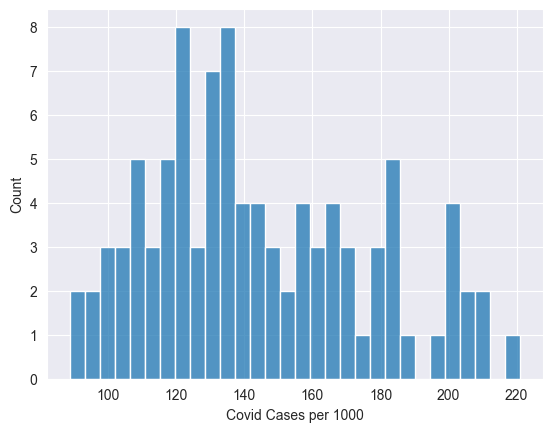

In [83]:
sns.histplot(data = Real_FSA_Cases, x = 'Covid Cases per 1000', bins=30)

<Axes: xlabel='Covid Cases per 1000'>

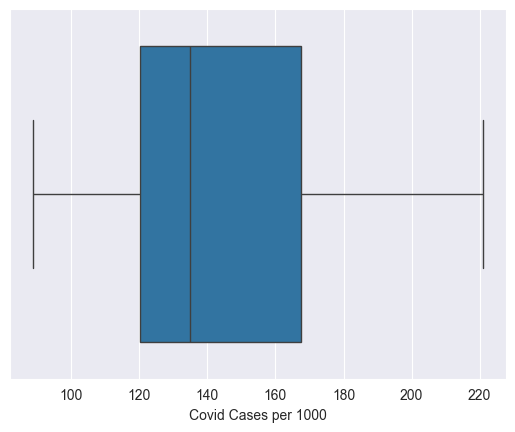

In [84]:
sns.boxplot(data = Real_FSA_Cases, x = 'Covid Cases per 1000')

Well that's lovely - I can work with that. Definitely some skew, but no outliers. Let's group our data weekly now to get it into a format we can begin comparing.

In [85]:
# Drop the non-real FSA's the same way we did on the area sums

covid_cases = covid_cases[covid_cases['FSA'].isin(FSA_map['CFSAUID'])]

In [86]:
covid_weekly_cases = covid_cases.groupby([
    pd.Grouper(key = 'Episode Date', freq = 'W'),
    'FSA'
]).agg({
      'Ever Hospitalized': 'sum', # these sums work because 1 = True in here
    'Ever in ICU': 'sum',
    'Ever Intubated': 'sum',
    '_id': 'nunique' # _id is the unique case id - there's no patient level identifier so there's a possibility the same person with different
})

In [87]:
covid_weekly_cases.rename({'_id': 'Weekly Cases'}, axis=1, inplace=True)

In [88]:
columns_to_normalize = ['Weekly Cases', 'Ever Hospitalized', 'Ever in ICU', 'Ever Intubated']

for col in columns_to_normalize:
    new_col_name = f'{col} per 1000'
    covid_weekly_cases.loc[:, new_col_name] = covid_weekly_cases[col] * covid_weekly_cases.index.get_level_values('FSA').map(multiplier)

In [89]:
covid_weekly_cases

Ever Hospitalized  Ever in ICU  Ever Intubated  \
Episode Date FSA                                                   
2020-01-26   M2N                  1            0               0   
             M5G                  0            0               0   
2020-02-02   M2L                  0            0               0   
             M6M                  0            0               0   
2020-02-09   M3A                  0            0               0   
...                             ...          ...             ...   
2024-02-18   M6E                  0            0               0   
             M6M                  0            0               0   
             M8Z                  0            0               0   
             M9N                  0            0               0   
             M9R                  0            0               0   

                  Weekly Cases  Weekly Cases per 1000  \
Episode Date FSA                                        
2020-01-26   M2N             2               0.026631   
             M5G             1               0.102554   
2020-02-02   M2L             1               0.088700   
             M6M             1               0.023726   
2020-02-09   M3A             1               0.029103   
...                        ...                    ...   
2024-02-18   M6E             1               0.026536   
             M6M             1               0.023726   
             M8Z             1               0.051781   
             M9N             1               0.038374   
             M9R             1               0.029601   

                  Ever Hospitalized per 1000  Ever in ICU per 1000  \
Episode Date FSA                                                     
2020-01-26   M2N                    0.013316                   0.0   
             M5G                    0.000000                   0.0   
2020-02-02   M2L                    0.000000                   0.0   
             M6M                    0.000000                   0.0   
2020-02-09   M3A                    0.000000                   0.0   
...                                      ...                   ...   
2024-02-18   M6E                    0.000000                   0.0   
             M6M                    0.000000                   0.0   
             M8Z                    0.000000                   0.0   
             M9N                    0.000000                   0.0   
             M9R                    0.000000                   0.0   

                  Ever Intubated per 1000  
Episode Date FSA                           
2020-01-26   M2N                      0.0  
             M5G                      0.0  
2020-02-02   M2L                      0.0  
             M6M                      0.0  
2020-02-09   M3A                      0.0  
...                                   ...  
2024-02-18   M6E                      0.0  
             M6M                      0.0  
             M8Z                      0.0  
             M9N                      0.0  
             M9R                      0.0  

[18165 rows x 8 columns]

-Okay, now getting the EMS calls - these are published by Toronto Paramedic Services, and give data on the FSA (there's definitely a pattern now), the dispatch triage priority, as well as a few other pieces. It comes in a big spreadsheet, so we're only going to pull the tabs for the years we care about (2020, 2021, 2022)

In [90]:
EMS_calls = pd.read_excel('paramedic-services-incident-data-2017-2022.xlsx', sheet_name='2020')


In [91]:
EMS_calls.Forward_Sortation_Area.value_counts().get('-')

np.int64(70)

In [92]:
# there's 177 events where we don't have an FSA - just going to filter those out for lack of a better idea
EMS_calls = EMS_calls[EMS_calls.Forward_Sortation_Area != '-']

Toronto uses some funky priority codes, according to the readme from the dataset:

| Priority | Description |
|----------|-------------|
| 1        | Delta       |
| 3        | Charlie     |
| 4        | Bravo       |
| 5        | Alpha       |
| 9        | Echo        |
| 11       | Alpha1      |
| 12       | Alpha2      |
| 13       | Alpha3      |
| 14       | Code 2      |

Going to map these to a smaller list of readable values then get dummy variables to go along with them.



In [93]:
Priority_name_map = {
    9: 'Resuscitation',
    1: 'High',
    3: 'High',
    4: 'Low',
    5: 'Low',
    11: 'Low',
    12: 'Low',
    13: 'Low'
}

EMS_calls['Priority_Name'] = EMS_calls['Priority_Number'].map(Priority_name_map)

In [94]:
EMS_calls = pd.get_dummies(EMS_calls, columns = ['Priority_Name'])

In [95]:
#Quickly filter out any calls for fires or car crashes, as well as any calls where no paramedics arrived at the scene.
Filtered_EMS_calls = EMS_calls[(EMS_calls['Incident_Type'] == 'Medical') & (EMS_calls['Units_Arrived_At_Scene'] > 0)]

In [96]:
Filtered_EMS_calls = Filtered_EMS_calls.rename(columns = {'Forward_Sortation_Area': 'FSA'})

Now we can look at it and see if we're actually making sense now

In [97]:
FSA_Calls = Filtered_EMS_calls['FSA'].value_counts().to_frame()

<Axes: xlabel='count'>

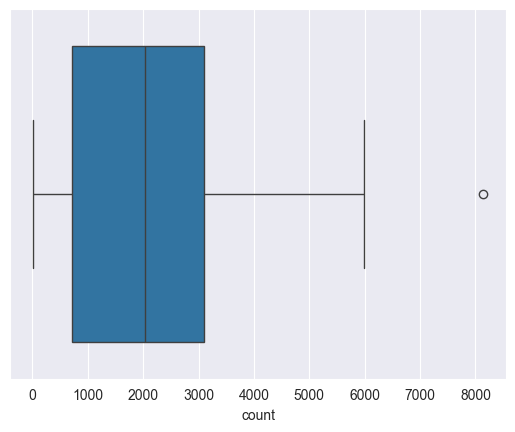

In [98]:
sns.boxplot(data = FSA_Calls, x = 'count')

<Axes: ylabel='Count'>

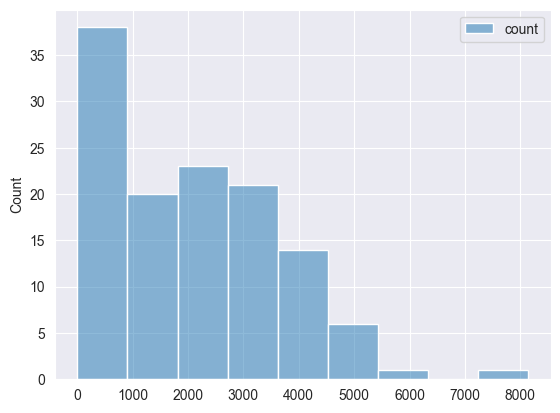

In [99]:
sns.histplot(data = FSA_Calls)

Well - that's a right skew for sure, let's normalize and see what we get

In [100]:
FSA_Calls.loc[:, 'EMS per 1000'] = FSA_Calls['count'] * FSA_Calls.index.map(multiplier)

<Axes: xlabel='EMS per 1000'>

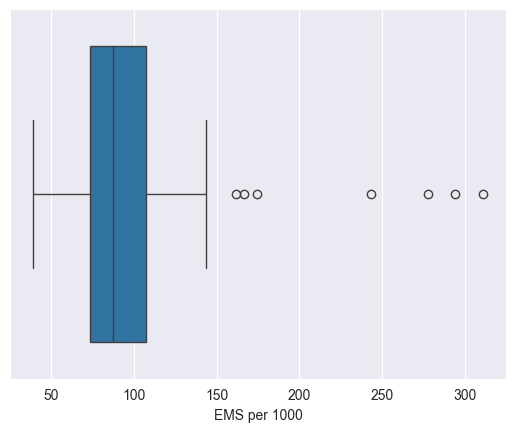

In [101]:
sns.boxplot(data = FSA_Calls, x = 'EMS per 1000')

Well that's better - a better distribution, though there's more outliers

In [102]:
EMS_weekly_cases = Filtered_EMS_calls.groupby([
    pd.Grouper(key='Dispatch_Time', freq='W'),
    'FSA'
]).agg({
    'ID': 'nunique',
    'Priority_Name_High' : 'sum',
    'Priority_Name_Low' : 'sum',
    'Priority_Name_Resuscitation' : 'sum'
}).reset_index()

In [103]:
covid_weekly_cases = covid_weekly_cases.rename({'Episode Date':'Week Start'},axis = 1)
EMS_weekly_cases = EMS_weekly_cases.rename({'Dispatch_Time':'Week Start', 'ID': 'EMS Calls'},axis = 1)

In [104]:
EMS_weekly_cases.loc[:, 'Weekly EMS Calls per 1000'] = EMS_weekly_cases['EMS Calls'] * EMS_weekly_cases['FSA'].map(multiplier)

In [105]:
EMS_weekly_cases.loc[:, '% of calls are High Acuity'] = (EMS_weekly_cases['Priority_Name_High'] + EMS_weekly_cases['Priority_Name_Resuscitation']) / EMS_weekly_cases['EMS Calls']


In [106]:
#Attach a geometry to each of these weeks
EMS_weekly_cases = EMS_weekly_cases.merge(FSA_map, left_on = 'FSA', right_on = 'CFSAUID', how = 'left')

In [107]:
gdf_EMS_weekly_cases = geopandas.GeoDataFrame(EMS_weekly_cases, geometry = 'geometry')

Now there's a stack of NaN in the new calls per 100 column - wonder if all the calls are actually in Toronto to get a number from?

<Axes: >

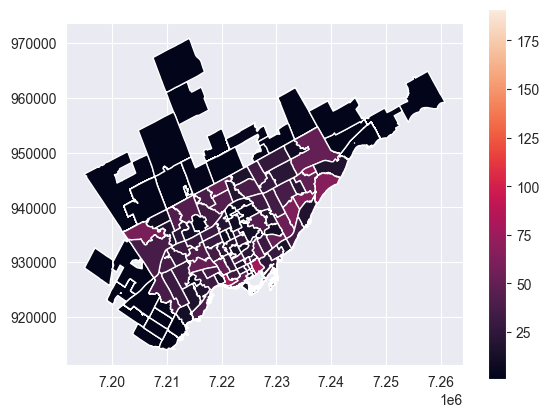

In [108]:
gdf_EMS_weekly_cases.plot(column = 'EMS Calls', legend = True)

Wait a second! There's way more there than just Toronto - lets filter it down. Looks like we can just drop columns where there wasn't a value since those are areas without pop data for Toronto itself.

In [109]:
EMS_weekly_cases = EMS_weekly_cases[EMS_weekly_cases['Weekly EMS Calls per 1000'].notna()]

Do some quick tidying up to get our columns consistent across the various DF

Now we can actually merge our data and see things!

In [110]:
weekly_data = covid_weekly_cases.merge(EMS_weekly_cases, left_index = True, right_on =['Week Start', 'FSA'] )

In [111]:
weekly_data = weekly_data.set_index(['Week Start', 'FSA'])

<Axes: xlabel='Weekly Cases per 1000', ylabel='Weekly EMS Calls per 1000'>

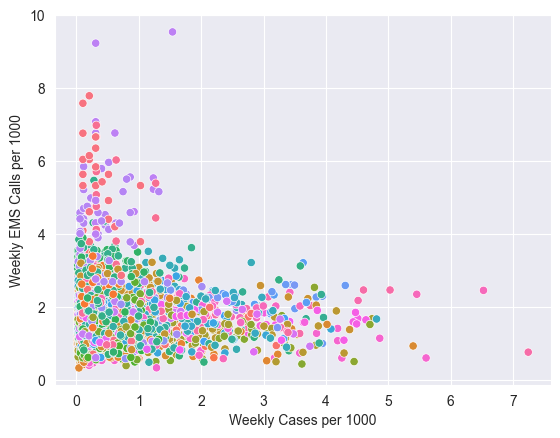

In [112]:
sns.scatterplot(weekly_data, x = 'Weekly Cases per 1000', y = 'Weekly EMS Calls per 1000', hue = 'FSA', legend = None)

Well. We can see the baseline EMS volume, and an interesting pattern where certain FSA's appear to have a high base volume but relatively consistently low case volume. Let's look at some averages as time goes by.

array([<Axes: xlabel='Week Start'>, <Axes: xlabel='Week Start'>],
      dtype=object)

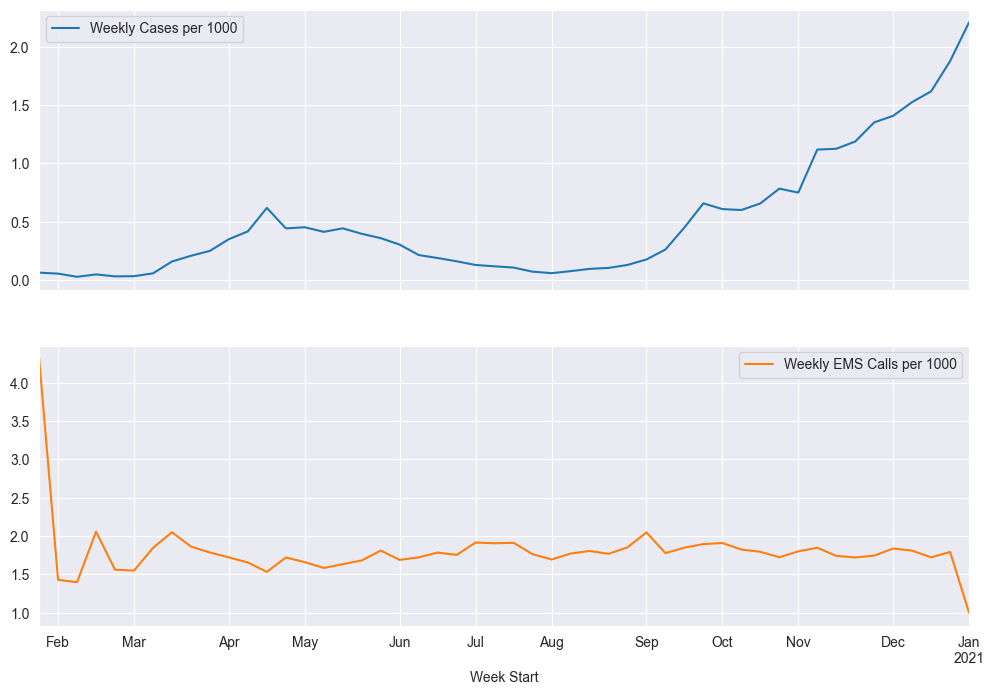

In [113]:
weekly_data.reset_index().groupby('Week Start').agg({
    'Weekly Cases per 1000': 'mean',
    'Weekly EMS Calls per 1000': 'mean'
}).plot(subplots=True, figsize=(12,8))

Well, that's not suggestive of any kind of relationship - if nothing else, I would expect to see a change but the EMS call volume is remarkably stable at the city level. Let's try looking at high acuity EMS calls and serious covid cases:

In [114]:
filtered_weekly_data = weekly_data[(weekly_data['Serious Case Indicators per 1000'] > 0) & (weekly_data['EMS Calls'] > 10)]

KeyError: 'Serious Case Indicators per 1000'

<Axes: xlabel='% of calls are High Acuity', ylabel='Serious Case Indicators per 1000'>

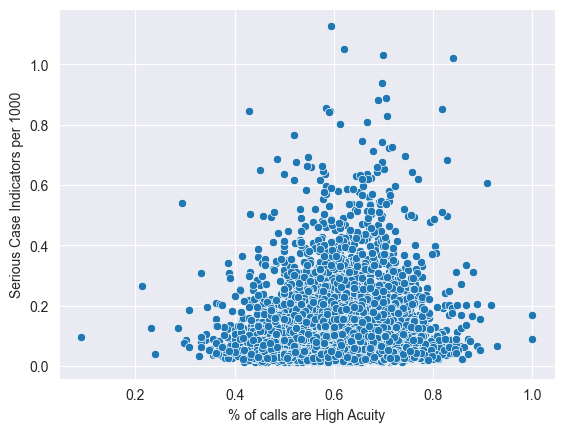

In [147]:
sns.scatterplot(filtered_weekly_data, x = '% of calls are High Acuity', y = 'Serious Case Indicators per 1000')

In [124]:
fsa_correlations = weekly_data.groupby('FSA').apply(
    lambda x: x['Weekly Cases per 1000'].corr(x['Weekly EMS Calls per 1000'])
)
print("FSAs with strongest/weakest correlations:", fsa_correlations.sort_values())

FSAs with strongest/weakest correlations: FSA
M6S   -0.215642
M5A   -0.192132
M5G   -0.184617
M4L   -0.177955
M5T   -0.161546
         ...   
M9V    0.345905
M9M    0.349254
M1B    0.357661
M3L    0.378406
M3N    0.404486
Length: 96, dtype: float64
